# Delaunay Testing

In [56]:
# imports
from importlib import reload

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
mpl.rcParams['font.family'] = 'stixgeneral'

import pandas
import seaborn as sns

from oceancolor.iop import cross
from oceancolor.utils import pca

from ihop.iops import pca as ihop_pca
from ihop.iops import delaunay
from ihop.iops import io as iops_io

from IPython import embed

In [4]:
%matplotlib ipympl

In [16]:
np.random.seed(12345)

# Load L23

In [8]:
reload(iops_io)
iop = 'a'
spec_w, wave, _ = iops_io.load_loisel23('a')

In [12]:
spec_w.shape

(3320, 81)

In [13]:
nspec = spec_w.shape[0]

# PCA a random set

## Grab the random ones

In [17]:
use_pca = np.zeros(nspec, dtype=bool)
r_pca = np.random.choice(np.arange(nspec), size=3000, replace=False)
#
use_pca[r_pca] = True

## PCA me

In [25]:
Ncomp = 4
pca_fit = pca.fit_normal(spec_w[use_pca], Ncomp)

## Check

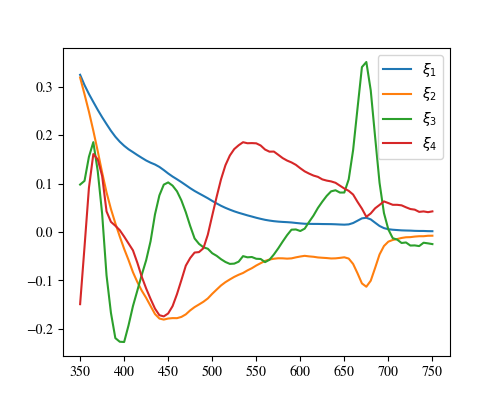

In [61]:
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

for ss in range(Ncomp):
    ax.plot(wave, pca_fit.components_[ss], label=r'$\xi_{'+f'{ss+1}'+r'}$')
ax.legend()
plt.show()

# Delaunay time

## Coefficients

In [27]:
coeff = pca_fit.transform(spec_w[use_pca])

## Build it (and they will come)

In [28]:
l23_delaunay = delaunay.build_delaunay(coeff)

## Check the others

In [29]:
held_out_coeff = pca_fit.transform(spec_w[~use_pca])
held_out_coeff.shape

(320, 4)

In [30]:
in_hull = delaunay.in_the_hull(held_out_coeff, l23_delaunay)

In [31]:
np.sum(in_hull)

300

## Are they unusual?

In [36]:
ood = np.where(~use_pca)[0][~in_hull]
ood

array([ 226,  344,  512,  514,  713,  891, 1149, 1317, 1384, 1544, 1674,
       1856, 1975, 2001, 2134, 2193, 2220, 2573, 2590, 2658])

In [47]:
spec_std = np.std(spec_w[use_pca], axis=0)
spec_std.shape

(81,)

In [48]:
spec_std

array([0.12786561, 0.11936941, 0.11207803, 0.105484  , 0.09896722,
       0.09285951, 0.08718341, 0.08173632, 0.07694881, 0.07294545,
       0.06964461, 0.06685844, 0.0646239 , 0.0623388 , 0.06019587,
       0.05813437, 0.05649398, 0.05516618, 0.05331741, 0.05084599,
       0.04812534, 0.04568325, 0.04351857, 0.04123617, 0.03881672,
       0.03632288, 0.03407587, 0.03208099, 0.03014034, 0.02814612,
       0.02595261, 0.02388158, 0.02194455, 0.02026293, 0.01879264,
       0.01743697, 0.01625478, 0.01520638, 0.01412398, 0.01315821,
       0.01214514, 0.01125338, 0.0104258 , 0.00980994, 0.00931733,
       0.00895899, 0.00871818, 0.00854474, 0.00829353, 0.00788872,
       0.00752677, 0.00721865, 0.00716629, 0.00712135, 0.00714584,
       0.00709117, 0.0070702 , 0.00705998, 0.00694421, 0.00676099,
       0.00661294, 0.00690022, 0.00819771, 0.01041815, 0.01270433,
       0.01331032, 0.01179014, 0.00866241, 0.00556162, 0.00357811,
       0.00258821, 0.00214878, 0.00188929, 0.00164168, 0.00152

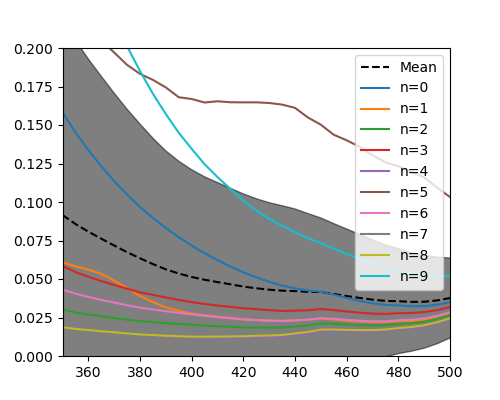

In [49]:

fig = plt.figure(figsize=(5,4))
ax = plt.gca()

# Mean
ax.plot(wave, pca_fit.mean_, 'k--', label='Mean')
ax.fill_between(wave, pca_fit.mean_-spec_std, pca_fit.mean_+spec_std, 
                color='k', alpha=0.5)

for ss in range(10):
    ax.plot(wave, spec_w[ood[ss]], label=f'n={ss}')
#
ax.set_xlim(350., 500.)
ax.set_ylim(0., 0.2)
ax.legend()
plt.show()

## Check the distributions

In [59]:
df = pandas.DataFrame()
for ss in range(4):
    df[f'a{ss+1}'] = [0.]*nspec
    df[f'a{ss+1}'].values[use_pca] = coeff[:,ss]
    df[f'a{ss+1}'].values[~use_pca] = held_out_coeff[:,ss]
    # Label
    if ss == 0:
        df['Sample'] = 'In'
        df['Sample'].values[ood] = 'Out'

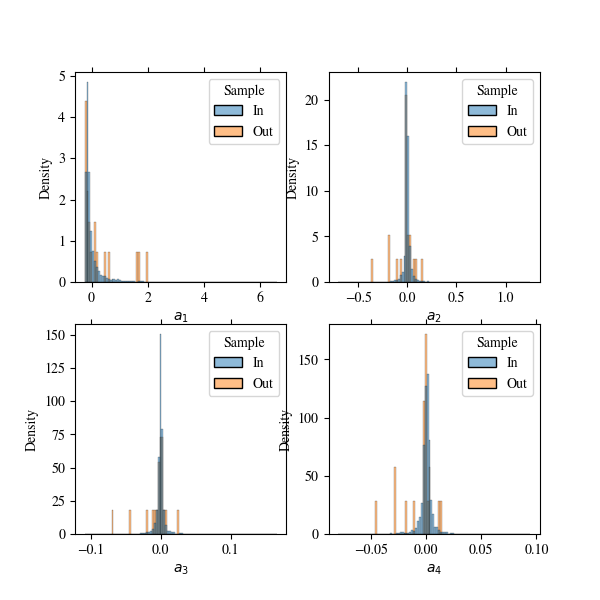

In [79]:
figsize=(6,6)
fig = plt.figure(figsize=figsize)
plt.clf()
gs = gridspec.GridSpec(2,2)

for ss in range(4):
    ax= plt.subplot(gs[ss])
    sns.histplot(df, x=f'a{ss+1}',
                 hue='Sample', 
                 ax=ax, bins=100,
            common_bins=True, stat='density', common_norm=False)
    # Label
    ax.set_xlabel(r'$a_'+f'{ss+1}'+'$')
    # Minor ticks
    ax.tick_params(axis='x', which='both', bottom=True, 
                   top=True, labelbottom=True, 
                   labeltop=False)
    # Fontsize
    #plotting.set_fontsize(ax, 12)
#
plt.show()

## 2D

/home/xavier/miniconda3/envs/os_11/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'common_bins', 'stat'
  cset = contour_func(


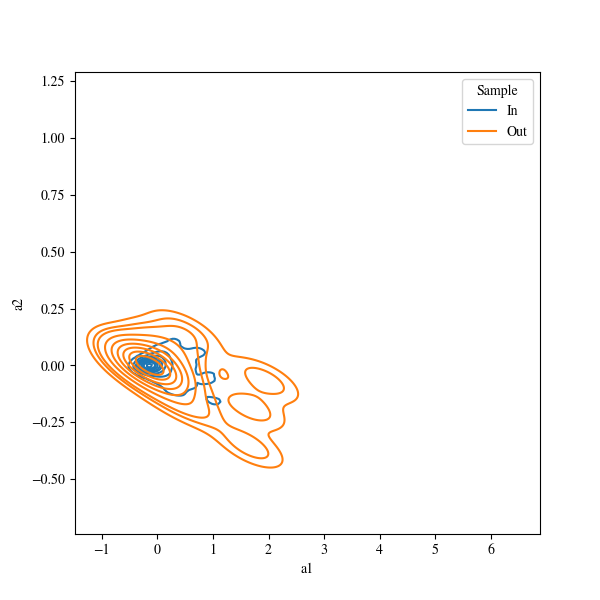

In [81]:
figsize=(6,6)
fig = plt.figure(figsize=figsize)

ii,jj = 0,1
sns.kdeplot(df, x=f'a{ii+1}', y=f'a{jj+1}',
                 hue='Sample', 
                 #bins=100,
            common_bins=True, stat='density', common_norm=False)
#
plt.show()

----

In [34]:
254./15

16.933333333333334

In [50]:
coeff.shape

(3000, 4)